In [9]:
#!pip install numpy pandas matplotlib scikit-learn tensorflow keras

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import os

## Carregando os dados e colocando a coluna 'Date' como índice

In [11]:
caminho_pasta = 'Base_dados'
lista_arquivos = [arquivo for arquivo in os.listdir(caminho_pasta) if os.path.isfile(os.path.join(caminho_pasta, arquivo))]

for arq in lista_arquivos:
    df = pd.read_csv(f'Base_dados/{arq}', parse_dates=['Date'])
    df = df.sort_values('Date')
    # Verificar se a coluna 'Date' existe e definir como índice
    # if 'Date' in df.columns:
    #     df = df.set_index('Date')
    print(df.head())


        Date    Open       High        Low      Close  Adj Close      Volume  \
0 2020-01-29  25.500  25.690001  24.680000  24.730000  17.712214  16800400.0   
1 2020-01-30  24.350  24.995001  24.184999  24.900000  17.833971  25079800.0   
2 2020-01-31  24.555  24.559999  24.110001  24.270000  17.382753  32252800.0   
3 2020-02-03  24.275  24.570000  24.004999  24.389999  17.468699  20402800.0   
4 2020-02-04  24.645  24.799999  24.125000  24.125000  17.278902  23533200.0   

    SMA_10     EMA_10     RSI_10      MACD  MACD_Histogram  BBL_20_2.0  \
0  24.9610  25.132101  40.316762 -0.407259        0.043456   23.842415   
1  24.9785  25.089901  43.272728 -0.397243        0.042777   23.898938   
2  24.8995  24.940828  35.942692 -0.435126        0.003916   23.906795   
3  24.8485  24.840677  38.159656 -0.450275       -0.008986   23.925546   
4  24.8430  24.710554  35.172752 -0.478152       -0.029490   23.906871   

   BBM_20_2.0  BBU_20_2.0  BBB_20_2.0  BBP_20_2.0   ATRr_14    stoch_k  \


In [12]:
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA_10', 'EMA_10', 
            'RSI_10', 'MACD', 'MACD_Histogram', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 
            'BBB_20_2.0', 'BBP_20_2.0', 'ATRr_14', 'stoch_k', 'stoch_d']

target = 'Adj Close'

X = df[features]
y = df[target]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

y = y.values

In [13]:
window_size = 60

X_seq = []
y_seq = []

for i in range(window_size, len(X_scaled)):
    X_seq.append(X_scaled[i-window_size:i])
    y_seq.append(y[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)



In [14]:
train_size = int(len(X_seq) * 0.7)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))



c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(optimizer='adam', loss='mse')



In [16]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 43760.3711 - val_loss: 871.0678
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3279.2761 - val_loss: 1323.5026
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1677.3143 - val_loss: 696.5972
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1317.9528 - val_loss: 649.1541
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1179.9130 - val_loss: 589.5237
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1022.5974 - val_loss: 533.5040
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 837.9228 - val_loss: 472.3558
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 853.2278 - val_loss: 446.4727
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 703.9971 - val_loss: 416.2029
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 586.5125 - val_loss: 347.6346
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 544.7371 - val_loss: 388.3169
Epoch 12/50

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MSE: 180.80106603797702
MAE: 10.498755110555619


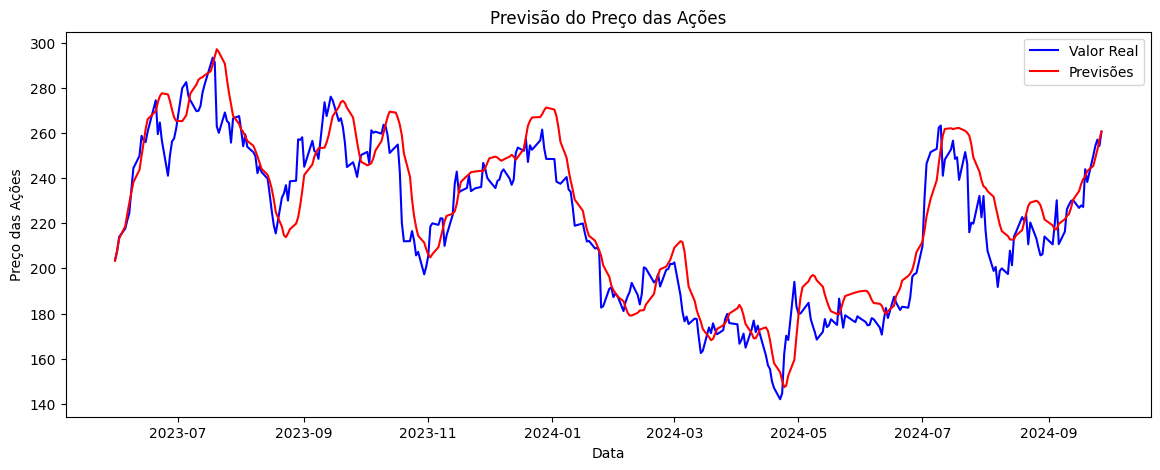

In [17]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAE: {mae}')
# Primeiro, precisamos saber os índices correspondentes aos dados de teste
test_dates = df['Date'][-len(y_test):]
test_dates = test_dates.reset_index(drop=True)

plt.figure(figsize=(14,5))
plt.plot(test_dates, y_test, color='blue', label='Valor Real')
plt.plot(test_dates, y_pred, color='red', label='Previsões')
plt.title('Previsão do Preço das Ações')
plt.xlabel('Data')
plt.ylabel('Preço das Ações')
plt.legend()
plt.show()




In [18]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_10,EMA_10,RSI_10,MACD,MACD_Histogram,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,ATRr_14,stoch_k,stoch_d
0,2020-01-30,42.161331,43.391998,41.200001,42.720669,42.720669,435085500.0,37.496600,37.734858,85.787607,2.639939,0.550914,27.812377,34.837566,41.862756,40.331117,1.061060,1.971172,87.117057,81.736019
1,2020-01-31,42.666668,43.533333,42.167999,43.371334,43.371334,235789500.0,38.410467,38.759672,86.677273,2.930907,0.673505,28.210692,35.571933,42.933175,41.387919,1.029761,1.915179,93.899932,87.137657
2,2020-02-03,44.912666,52.409332,44.901333,52.000000,52.000000,705975000.0,40.207133,41.167004,93.069622,3.813799,1.245117,26.906177,36.695233,46.484289,53.353283,1.281728,2.559948,96.906199,92.641063
3,2020-02-04,58.863998,64.599335,55.591999,59.137333,59.137333,914082000.0,42.472867,44.434337,95.190505,5.031421,1.970192,24.751718,38.146966,51.542215,70.229691,1.283500,3.451703,93.073154,94.626429
4,2020-02-05,54.883999,56.398666,46.940666,48.980000,48.980000,726357000.0,43.573800,45.260821,64.148610,5.117789,1.645248,25.237119,39.032433,52.827747,70.686417,0.860541,4.215197,77.197608,89.058987


In [19]:
years = df['Date'].dt.year.unique()

mses = []
maes = []
mses_geral = []
maes_geral = []
std_mses_geral =[]
std_maes_geral = []
for i in range (10): 
    
    for year in years[:-1]:  # Excluindo o último ano para ter dados para testar
        # Dados de treinamento até o ano atual
        train_data = df[df['Date'].dt.year <= year]
        test_data = df[df['Date'].dt.year == year+1]
        
        if len(test_data) < window_size:
            continue  # Pula se não houver dados suficientes para testar
        
        # Preparar dados de treinamento
        X_train = train_data[features].values
        y_train = train_data[target].values
        X_train_scaled = scaler.fit_transform(X_train)
        
        X_train_seq = []
        y_train_seq = []
        for i in range(window_size, len(X_train_scaled)):
            X_train_seq.append(X_train_scaled[i-window_size:i])
            y_train_seq.append(y_train[i])
        X_train_seq = np.array(X_train_seq)
        y_train_seq = np.array(y_train_seq)
        
        # Preparar dados de teste
        X_test = test_data[features].values
        y_test = test_data[target].values
        X_test_scaled = scaler.transform(X_test)
        
        X_test_seq = []
        y_test_seq = []
        for i in range(window_size, len(X_test_scaled)):
            X_test_seq.append(X_test_scaled[i-window_size:i])
            y_test_seq.append(y_test[i])
        X_test_seq = np.array(X_test_seq)
        y_test_seq = np.array(y_test_seq)
        
        # Verificar se há dados suficientes
        if X_train_seq.shape[0] == 0 or X_test_seq.shape[0] == 0:
            continue
        
        # Construir e treinar o modelo
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=0)
        
        # Fazer previsões
        y_pred = model.predict(X_test_seq)
        
        # Calcular métricas
        mse = mean_squared_error(y_test_seq, y_pred)
        mae = mean_absolute_error(y_test_seq, y_pred)
        mses.append(mse)
        maes.append(mae)
        
        print(f'Ano {year+1}: MSE = {mse}, MAE = {mae}')

    mean_mse = np.mean(mses)
    std_mse = np.std(mses)
    mean_mae = np.mean(maes)
    std_mae = np.std(maes)
    mses_geral.append(mean_mse)
    std_mses_geral.append(std_mse)
    maes_geral.append(mean_mae)
    std_maes_geral.append(std_mae)

mean_mse_final = np.mean(mses_geral)
std_mse_final = np.std(std_mses_geral)
mean_mae_final = np.mean(maes_geral)
std_mae_final = np.std(std_maes_geral)
print(f'\nMédia MSE: {mean_mse_final}, Desvio Padrão MSE: {std_mse_final}')
print(f'Média MAE: {mean_mae_final}, Desvio Padrão MAE: {std_mae_final}')



c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Ano 2021: MSE = 2309.312541614898, MAE = 42.77876218159994


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Ano 2022: MSE = 732.8950199184175, MAE = 22.112410700133957


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Ano 2023: MSE = 224.64080057214133, MAE = 11.825088099429479


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000191F34C7640> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Ano 2024: MSE = 254.34526371788482, MAE = 12.766733124500181


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Ano 2021: MSE = 1965.4941810317869, MAE = 39.300230264663696


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Ano 2022: MSE = 998.595035554225, MAE = 26.766864477027774


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Ano 2023: MSE = 221.61213829776784, MAE = 11.281936725817227


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Ano 2024: MSE = 250.4676013893161, MAE = 12.898939958707551


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Ano 2021: MSE = 2104.715018063973, MAE = 39.89952754974365


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Ano 2022: MSE = 1141.8823033223307, MAE = 28.960675863695393


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Ano 2023: MSE = 259.4331469317542, MAE = 12.725401466771176


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ano 2024: MSE = 291.69844254290155, MAE = 13.942389180341104


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Ano 2021: MSE = 1650.3541805215452, MAE = 34.650070667266846


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Ano 2022: MSE = 1264.6568112537545, MAE = 30.4579783334782


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Ano 2023: MSE = 254.05504513072145, MAE = 12.232412077251233


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Ano 2024: MSE = 266.81850158407593, MAE = 13.336371113934854


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Ano 2021: MSE = 1869.3445170658622, MAE = 37.675708611806236


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Ano 2022: MSE = 993.4151360127015, MAE = 26.505253177662794


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ano 2023: MSE = 251.07971708596142, MAE = 12.432738454718338


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Ano 2024: MSE = 223.15962915101414, MAE = 11.689217274583227


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Ano 2021: MSE = 1653.6394366370307, MAE = 34.27087998390198


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Ano 2022: MSE = 940.3097126418743, MAE = 25.552758661240183


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Ano 2023: MSE = 214.39170437771824, MAE = 11.676973202354029


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Ano 2024: MSE = 250.6354876669255, MAE = 12.661084032434175


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Ano 2021: MSE = 1604.931789475715, MAE = 33.376700003941856


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Ano 2022: MSE = 1010.0224406480629, MAE = 26.07386747829577


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Ano 2023: MSE = 221.74919692765133, MAE = 11.685331645764803


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Ano 2024: MSE = 292.61696300893925, MAE = 14.178934412678396


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Ano 2021: MSE = 1697.5374491066868, MAE = 35.18293213844299


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ano 2022: MSE = 908.2792514062832, MAE = 25.218138609881176


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Ano 2023: MSE = 221.04457216996352, MAE = 11.628859509919817


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Ano 2024: MSE = 251.66837644777766, MAE = 12.971741323395975


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Ano 2021: MSE = 1533.9896456547758, MAE = 33.320198933283486


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Ano 2022: MSE = 1050.316226984849, MAE = 26.40949668684555


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Ano 2023: MSE = 200.11466774632171, MAE = 11.166223787006576


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Ano 2024: MSE = 242.97505369431912, MAE = 12.514131561038997


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Ano 2021: MSE = 1753.315425742129, MAE = 36.10178311665853


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Ano 2022: MSE = 1104.555684168163, MAE = 28.40965183118251


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Ano 2023: MSE = 209.04572200827224, MAE = 11.278278471294202


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Ano 2024: MSE = 261.5121732931161, MAE = 13.211111594372847

Média MSE: 860.8858009055806, Desvio Padrão MSE: 56.82478866012767
Média MAE: 22.424630756464065, Desvio Padrão MAE: 0.6537436621936817


In [25]:
print(std_mses_geral)

[849.3399481220339, 783.1672989441674, 774.8226246814153, 738.0636936132975, 725.774212996266, 706.0652022271652, 688.3412696158977, 678.6292507766002, 667.1733419544078, 664.4737832539993]


In [26]:
years = df['Date'].dt.year.unique()

mses = []
maes = []
mses_geral = []
maes_geral = []
std_mses_geral =[]
std_maes_geral = []
for i in range (10): 
    print("Loop: ", i)
    
    for year in years[:-1]:  # Excluindo o último ano para ter dados para testar
        # Dados de treinamento até o ano atual
        train_data = df[df['Date'].dt.year <= year]
        test_data = df[df['Date'].dt.year == year+1]
        
        if len(test_data) < window_size:
            continue  # Pula se não houver dados suficientes para testar
        
        # Preparar dados de treinamento
        X_train = train_data[features].values
        y_train = train_data[target].values
        X_train_scaled = scaler.fit_transform(X_train)
        
        X_train_seq = []
        y_train_seq = []
        for i in range(window_size, len(X_train_scaled)):
            X_train_seq.append(X_train_scaled[i-window_size:i])
            y_train_seq.append(y_train[i])
        X_train_seq = np.array(X_train_seq)
        y_train_seq = np.array(y_train_seq)
        
        # Preparar dados de teste
        X_test = test_data[features].values
        y_test = test_data[target].values
        X_test_scaled = scaler.transform(X_test)
        
        X_test_seq = []
        y_test_seq = []
        for i in range(window_size, len(X_test_scaled)):
            X_test_seq.append(X_test_scaled[i-window_size:i])
            y_test_seq.append(y_test[i])
        X_test_seq = np.array(X_test_seq)
        y_test_seq = np.array(y_test_seq)
        
        # Verificar se há dados suficientes
        if X_train_seq.shape[0] == 0 or X_test_seq.shape[0] == 0:
            continue
        
        model = Sequential()

        # Primeira camada Conv1D
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
                         input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))

        # Segunda camada Conv1D
        model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))

        # Terceira camada Conv1D
        model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))

        # Camada Flatten
        model.add(Flatten())

        # Camada densa
        model.add(Dense(100, activation='relu'))

        # Camada de saída
        model.add(Dense(1))

        # Compilação do modelo
        model.compile(optimizer='adam', loss='mse')

        # Treinamento do modelo
        model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=1)
        
        # Fazer previsões
        y_pred = model.predict(X_test_seq)
        
        # Calcular métricas
        mse = mean_squared_error(y_test_seq, y_pred)
        mae = mean_absolute_error(y_test_seq, y_pred)
        mses.append(mse)
        maes.append(mae)
        
        # print(f'Ano {year+1}: MSE = {mse}, MAE = {mae}')

    mean_mse = np.mean(mses)
    std_mse = np.std(mses)
    mean_mae = np.mean(maes)
    std_mae = np.std(maes)
    mses_geral.append(mean_mse)
    std_mses_geral.append(std_mse)
    maes_geral.append(mean_mae)
    std_maes_geral.append(std_mae)

mean_mse_final = np.mean(mses_geral)
std_mse_final = np.std(std_mses_geral)
mean_mae_final = np.mean(maes_geral)
std_mae_final = np.std(std_maes_geral)
print(f'\nMédia MSE: {mean_mse_final}, Desvio Padrão MSE: {std_mse_final}')
print(f'Média MAE: {mean_mae_final}, Desvio Padrão MAE: {std_mae_final}')



Loop:  0


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 15337.6797
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2957.7061
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1488.0980
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 741.3538
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 803.0228
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 652.5632
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 448.8671
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 360.7597
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 317.7055
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 284.6153
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 255.7655
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 238.4417
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 214.8151
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 193.2785
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 193.5422


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 31757.5332
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 3714.1189
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1311.4664
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1017.5828
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 814.5762
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 637.6440
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 792.1682
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 564.3356
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 504.0049
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 452.0000
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 507.3495
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 412.3570
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 357.7629
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 340.8916
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 31969.6621
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 2188.6162
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 1192.5511
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 880.5704
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 741.6788
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 525.3152
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 512.0594
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 471.0892
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 528.9716
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 445.0783
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 319.1618
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 297.9098
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 333.9220
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 306.6772
Epoch 15/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 29207.4961
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 1555.2101
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 833.2934
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 609.6404
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 532.4158
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 405.2982
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 337.8849
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 347.9411
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 245.1237
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 214.8629
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 214.3242
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 228.9513
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 162.5295
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 157.5986
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 15441.7168
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 2259.1182
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1137.1227
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 582.5377
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 489.7185
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 584.6276
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 438.7191
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 384.5165
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 313.1456
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 290.3675
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 306.1674
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 279.1931
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 246.9481
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 219.8707
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 194.7751


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 37807.4492
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3459.3357
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1126.1058
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 849.9776
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 801.1190
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 650.0806
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 540.0942
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 461.0715
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 416.0747
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 395.9883
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 350.2795
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 442.7976
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 378.9579
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 375.9892
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 34795.5938
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 2472.5369
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1296.6796
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 894.9101
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 704.0498
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 506.9308
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 503.4406
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 465.2598
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 381.8029
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 524.8811
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 472.6595
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 321.7324
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 358.3199
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 289.0304
Epoch 15/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 28609.9805
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 1725.6506
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 895.2444
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 590.1588
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 508.7800
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 393.8217
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 340.2066
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 278.4359
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 264.6808
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 213.0405
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 171.6420
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 158.4470
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 166.9463
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 152.8951
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 15362.7754
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 2669.6904
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 1676.3705
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 561.3341
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 382.8705
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 399.7145
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 363.9072
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 283.7259
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 331.7878
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 270.5647
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 241.5189
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 237.3981
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 238.9288
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 208.0215
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 232.0069


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 33710.9688
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4037.5361
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1022.2527
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 695.5995
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 634.9594
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 484.9514
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 527.2947
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 474.5910
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 448.8573
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 383.3416
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 339.4208
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 344.7734
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 347.5328
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 364.7638
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 30651.3145
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 2668.1375
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1449.9688
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 860.6511
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 690.0308
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 600.2259
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 547.7799
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 553.1895
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 409.5221
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 332.1552
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 351.7791
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 346.0873
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 267.7619
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 205.1646
Epoch 15/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 25386.8945
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 1563.5964
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 804.7401
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 590.1741
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 479.4873
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 402.6988
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 379.7134
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 304.6411
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 441.6597
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 321.3335
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 413.8866
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 233.4082
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 190.8537
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 172.8626
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 16234.3984
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 2168.3259
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1264.1132
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 676.1827
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 464.1521
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 284.6516
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 342.0282
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 320.5732
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 233.0222
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 250.4483
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 211.1720
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 193.1517
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 215.8001
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 189.4473
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 163.9204


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 36008.5391
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3830.6484
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1406.1859
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 914.6938
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 866.8199
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 536.8627
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 550.9573
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 553.6472
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 441.9968
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 425.8539
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 416.8314
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 346.3919
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 466.9734
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 375.6814
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 31396.7109
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 2445.7656
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1286.3688
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 985.7167
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 719.9150
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 497.6185
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 524.1610
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 399.2219
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 375.6386
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 302.0797
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 254.9590
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 314.2662
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 389.7220
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 204.9722
Epoch 15/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 28828.1738
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 1442.1577
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 887.1025
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 486.2672
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 487.8695
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 423.3923
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 285.1284
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 269.3265
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 237.0686
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 181.7954
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 201.2781
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 169.1916
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 141.2160
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 157.3985
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 15701.9482
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2042.5413
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 991.4443
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 637.4332
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 529.0616
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 537.0990
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 293.2769
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 271.0694
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 271.9693
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 219.8113
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 231.7125
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 221.6161
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 217.6081
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 243.6347
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 204.4460
E

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 35142.1367
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 2916.4780
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1117.7606
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 833.9592
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 639.7767
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 542.4664
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 549.4132
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 454.2428
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 422.7910
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 378.6524
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 555.9740
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 350.7893
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 410.2351
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 317.0884
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 36521.9883
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 2914.5361
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1156.6194
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 785.5903
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 757.0177
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 611.2268
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 518.0585
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 515.1396
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 469.0979
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 415.7761
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 406.7911
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 373.2475
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 311.0124
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 325.4447
Epoch 15/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 27725.3398
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 1451.4207
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 805.7144
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 632.5897
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 567.1935
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 400.6368
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 436.0890
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 352.6603
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 348.8823
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 299.7042
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 232.3622
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 198.8863
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 209.5189
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 228.7187
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 15404.6650
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2547.8540
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1067.2690
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 789.5967
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 620.3914
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 414.0402
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 322.8205
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 260.5815
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 237.0400
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 192.1111
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 222.3556
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 211.2311
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 211.3927
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 236.8435
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 235.4454

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 34329.6289
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3502.0503
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1284.1897
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 970.3729
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 807.0610
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 629.0060
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 463.8362
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 446.3468
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 403.9817
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 423.6747
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 497.3100
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 483.5806
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 441.8397
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 383.5058
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 33803.0312
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 2588.0256
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1322.7805
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1057.9065
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 723.7743
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 613.7122
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 546.9802
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 457.7127
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 447.3996
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 385.0776
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 303.8692
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 244.9219
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 302.1123
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 233.0659
Epoch 15/20
22/22 ━━━━━━━━━━━━━━━━━━━━

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 27721.6719
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 1455.2025
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 874.5533
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 621.0201
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 442.0140
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 379.0379
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 328.2025
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 281.6416
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 310.0939
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 218.4970
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 238.3664
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 180.0987
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 169.1874
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 141.8871
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 14407.1904
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 2270.0217
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1512.8191
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 530.1901
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 369.9181
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 428.3603
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 395.1901
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 300.6937
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 254.1944
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 267.3813
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 233.0579
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 254.2432
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 218.2120
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 209.5676
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 198.9049


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 37165.8359
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4769.5215
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1895.5331
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1389.0452
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 800.7816
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 778.7258
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 584.2568
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 533.9948
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 544.9246
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 468.4622
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 464.5112
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 523.6207
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 418.2261
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 362.9351
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 33503.3984
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2336.5654
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1174.1177
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 941.2175
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 650.8594
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 551.4212
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 495.5276
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 450.5171
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 467.9361
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 348.0224
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 374.5324
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 292.4643
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 258.6599
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 273.1753
Epoch 15/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 26922.7539
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 1431.3928
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 876.7148
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 583.2531
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 424.2755
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 390.7625
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 422.7420
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 292.8647
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 320.2733
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 246.8793
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 200.0803
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 174.1640
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 165.1054
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 155.6113
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 14862.0781
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3684.8992
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1061.3469
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1279.8181
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 915.4244
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 497.4007
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 320.5739
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 249.1969
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 218.0150
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 242.1958
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 230.6907
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 185.7498
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 235.8221
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 187.6114
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 210.1383

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 31669.3867
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3673.6880
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1292.8224
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 721.0925
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 543.8486
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 596.0907
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 514.0613
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 452.4783
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 408.4951
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 387.1169
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 358.2418
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 305.4011
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 345.8611
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 327.6904
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 32479.7461
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2666.3323
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 1237.6115
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 907.5941
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 723.1675
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 609.4933
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 518.4141
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 490.1761
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 426.1127
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 390.6004
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 359.9319
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 396.5455
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 293.5131
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 273.0546
Epoch 15/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 26090.6914
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 1979.1132
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 954.3802
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 509.4999
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 459.2173
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 444.7775
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 347.1388
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 285.9419
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 304.4139
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 208.7239
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 223.0819
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 176.7587
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 151.0707
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 170.0535
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 16404.2148
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2772.9324
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 1571.1882
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 908.4574
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 653.4111
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 649.7493
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 473.7193
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 361.1826
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 282.9289
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 258.8694
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 223.9151
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 256.6904
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 224.2348
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 195.6928
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 194.7312


c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 36953.8516
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3807.4609
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1290.3992
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 864.2885
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 779.0022
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 608.8967
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 521.6810
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 477.7324
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 520.6744
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 410.4291
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 469.8115
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 351.0719
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 346.3666
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 341.2151
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 31516.5293
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 2348.1777
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1380.5605
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 774.9540
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 631.6708
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 505.9102
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 399.7497
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 513.3528
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 357.5967
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 342.6119
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 273.6861
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 298.6983
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 244.5579
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 217.5973
Epoch 15/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 28299.3770
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 1356.4661
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 720.5869
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 647.0895
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 459.1284
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 389.0955
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 351.4872
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 262.1021
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 286.9836
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 208.6402
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 192.5375
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 186.7047
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 162.0911
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 159.8075
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 14341.8379
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 2283.4180
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1825.8500
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 738.2505
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 464.6861
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 589.2002
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 459.7719
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 359.4814
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 266.3492
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 258.5076
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 297.5150
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 224.7922
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 196.9474
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 206.5206
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 192.8381

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 32687.6523
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3151.5815
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1564.4172
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1077.1002
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 779.6318
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 626.2197
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 751.6024
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 439.3138
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 409.8711
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 439.5236
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 383.2082
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 389.0041
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 350.8070
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 329.9358
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 34051.2578
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 2560.2798
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1153.3876
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 785.5717
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 690.8988
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 677.3411
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 429.2630
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 421.6107
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 379.6172
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 258.7015
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 268.7401
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 215.9362
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 222.8354
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 234.1567
Epoch 15/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 27045.7207
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 1607.3458
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 876.5123
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 613.3605
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 446.9164
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 383.0516
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 335.0671
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 327.2458
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 317.6524
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 235.5583
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 183.9035
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 164.3056
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 140.4864
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 161.3066
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3

### 3 Camadas de Conv1

In [29]:
with open('./resultado_tres_camadas.txt','w') as w:
    w.write("""
years = df['Date'].dt.year.unique()

mses = []
maes = []
mses_geral = []
maes_geral = []
std_mses_geral =[]
std_maes_geral = []
for i in range (10): 
    print("Loop: ", i)
    
    for year in years[:-1]:  # Excluindo o último ano para ter dados para testar
        # Dados de treinamento até o ano atual
        train_data = df[df['Date'].dt.year <= year]
        test_data = df[df['Date'].dt.year == year+1]
        
        if len(test_data) < window_size:
            continue  # Pula se não houver dados suficientes para testar
        
        # Preparar dados de treinamento
        X_train = train_data[features].values
        y_train = train_data[target].values
        X_train_scaled = scaler.fit_transform(X_train)
        
        X_train_seq = []
        y_train_seq = []
        for i in range(window_size, len(X_train_scaled)):
            X_train_seq.append(X_train_scaled[i-window_size:i])
            y_train_seq.append(y_train[i])
        X_train_seq = np.array(X_train_seq)
        y_train_seq = np.array(y_train_seq)
        
        # Preparar dados de teste
        X_test = test_data[features].values
        y_test = test_data[target].values
        X_test_scaled = scaler.transform(X_test)
        
        X_test_seq = []
        y_test_seq = []
        for i in range(window_size, len(X_test_scaled)):
            X_test_seq.append(X_test_scaled[i-window_size:i])
            y_test_seq.append(y_test[i])
        X_test_seq = np.array(X_test_seq)
        y_test_seq = np.array(y_test_seq)
        
        # Verificar se há dados suficientes
        if X_train_seq.shape[0] == 0 or X_test_seq.shape[0] == 0:
            continue
        
        model = Sequential()

        # Primeira camada Conv1D
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
                         input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))

        # Segunda camada Conv1D
        model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))

        # Terceira camada Conv1D
        model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))

        # Camada Flatten
        model.add(Flatten())

        # Camada densa
        model.add(Dense(100, activation='relu'))

        # Camada de saída
        model.add(Dense(1))

        # Compilação do modelo
        model.compile(optimizer='adam', loss='mse')

        # Treinamento do modelo
        model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=1)
        
        # Fazer previsões
        y_pred = model.predict(X_test_seq)
        
        # Calcular métricas
        mse = mean_squared_error(y_test_seq, y_pred)
        mae = mean_absolute_error(y_test_seq, y_pred)
        mses.append(mse)
        maes.append(mae)
        
        # print(f'Ano {year+1}: MSE = {mse}, MAE = {mae}')

    mean_mse = np.mean(mses)
    std_mse = np.std(mses)
    mean_mae = np.mean(maes)
    std_mae = np.std(maes)
    mses_geral.append(mean_mse)
    std_mses_geral.append(std_mse)
    maes_geral.append(mean_mae)
    std_maes_geral.append(std_mae)

mean_mse_final = np.mean(mses_geral)
std_mse_final = np.std(std_mses_geral)
mean_mae_final = np.mean(maes_geral)
std_mae_final = np.std(std_maes_geral)
print(f'\nMédia MSE: {mean_mse_final}, Desvio Padrão MSE: {std_mse_final}')
print(f'Média MAE: {mean_mae_final}, Desvio Padrão MAE: {std_mae_final}')
            
# Média MSE: 943.0044320935613, Desvio Padrão MSE: 214.6488998805015
# Média MAE: 22.229090372977968, Desvio Padrão MAE: 2.0232980342977402


            """)

In [20]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mse')

model.fit(X_train_seq, y_train_seq, epochs=30, batch_size=16, verbose=0)



c:\Users\amigo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
